<a href="https://colab.research.google.com/github/aajraou/agentic-ai-for-analytics/blob/main/Gaming_Analytics_Agentic_AI_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaming Analytics Agentic AI - Google Colab Version

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/)

## Overview

This notebook implements an **agentic AI workflow** for live chat analytics on gaming data. This version is optimized for **Google Colab** and supports both:

- **CSV files** (for testing and development)
- **Vertica database** (for production use)

### Key Features:

1. **Natural Language Queries**: Ask questions in plain English
2. **Automated SQL Generation**: Converts questions to SQL queries
3. **Data Retrieval**: Works with CSV files or Vertica database
4. **Visualization Generation**: Creates charts automatically
5. **Reflection Mechanism**: Self-evaluates and improves responses
6. **Google Colab Compatible**: Runs seamlessly in Colab environment

## 1. Setup and Installation

Install all required dependencies:

In [ ]:
# Install required packages
!pip install -q langchain langchain-community langgraph langchain-openai
!pip install -q matplotlib seaborn plotly pandas numpy
!pip install -q pandasql  # For SQL queries on pandas DataFrames
!pip install -q vertica-python  # Optional: for Vertica connection

print("✓ All packages installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 18.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.8/191.8 k

## 2. Import Libraries

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from typing import TypedDict, Annotated, List, Dict, Any
import operator
from pandasql import sqldf

# LangChain imports
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain.agents import AgentExecutor, create_tool_calling_agent

# LangGraph imports
from langgraph.graph import StateGraph, END

# For LLM - using OpenAI API compatible endpoint
from langchain_openai import ChatOpenAI

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## 3. Configuration

Choose your data source: CSV files or Vertica database

In [ ]:
# ============================================
# DATA SOURCE CONFIGURATION
# ============================================

# Set to 'csv' for testing with CSV files, or 'vertica' for production
DATA_SOURCE = 'csv'  # Change to 'vertica' when ready for production

# ============================================
# CSV FILE PATHS (for testing)
# ============================================

CSV_FILES = {
    'events': 'events.csv',
    'user_profiles': 'user_profiles.csv',
    'group_profiles': 'group_profiles.csv',
    'lookup_table': 'lookup_table.csv'
}

# ============================================
# VERTICA DATABASE CONFIGURATION (for production)
# ============================================

VERTICA_CONFIG = {
    'host': 'your-vertica-host.com',
    'port': 5433,
    'database': 'gaming_analytics',
    'user': 'your_username',
    'password': 'your_password',
    'read_timeout': 600,
    'unicode_error': 'strict',
    'ssl': False
}

# ============================================
# LLM CONFIGURATION
# ============================================

# Using OpenAI API (or compatible endpoint like Ollama with OpenAI compatibility)
# For Ollama: set base_url to 'http://localhost:11434/v1'
# For OpenAI: leave base_url as None and set OPENAI_API_KEY

LLM_CONFIG = {
    'model': 'gpt-5-nano',  # 'gpt-4.1-mini' or 'gpt-3.5-turbo', 'llama3.2', etc.
    'temperature': 0.1,
    'base_url': None  # Set to 'http://localhost:11434/v1' for Ollama
}

# Output directory for visualizations
OUTPUT_DIR = './visualizations'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"✓ Configuration set!")
print(f"  Data Source: {DATA_SOURCE.upper()}")
print(f"  LLM Model: {LLM_CONFIG['model']}")

✓ Configuration set!
  Data Source: CSV
  LLM Model: gpt-5-nano


## 4. Upload CSV Files (for CSV mode)

If using CSV mode, upload your data files in the same folder or decomment this section and upload the data

In [ ]:
# @title
# if DATA_SOURCE == 'csv':
#     print("CSV Mode: Upload your CSV files")
#     print("="*50)

    # Check if running in Colab
#     try:
#         from google.colab import files
#         IN_COLAB = True
#     except:
#         IN_COLAB = False

#     if IN_COLAB:
#         print("Running in Google Colab - Upload files below:")
#         uploaded = files.upload()
#         print(f"\n✓ Uploaded {len(uploaded)} file(s)")
#     else:
#         print("Not in Colab - Make sure CSV files are in the same directory")
#         print("Expected files:")
#         for table, filename in CSV_FILES.items():
#             print(f"  - {filename}")
# else:
#     print("Vertica Mode: CSV upload not needed")

## 5. Load Data

Load data from CSV files or connect to Vertica:

In [ ]:
# Global variable to store loaded DataFrames
DATA_TABLES = {}

if DATA_SOURCE == 'csv':
    print("Loading data from CSV files...")

    for table_name, filename in CSV_FILES.items():
        try:
            df = pd.read_csv(filename)
            DATA_TABLES[table_name] = df
            print(f"✓ Loaded {table_name}: {len(df)} rows, {len(df.columns)} columns")
        except FileNotFoundError:
            print(f"⚠ Warning: {filename} not found. Skipping {table_name}.")
        except Exception as e:
            print(f"✗ Error loading {filename}: {e}")

    print(f"\n✓ Loaded {len(DATA_TABLES)} tables successfully!")

else:
    print("Vertica Mode: Data will be queried directly from database")
    # Vertica connection will be established on-demand
    print("✓ Vertica configuration ready")

Loading data from CSV files...


/tmp/ipython-input-336248236.py:9: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


✓ Loaded events: 124006 rows, 31 columns
✓ Loaded user_profiles: 5000 rows, 29 columns
✓ Loaded group_profiles: 200 rows, 26 columns
✓ Loaded lookup_table: 1000 rows, 24 columns

✓ Loaded 4 tables successfully!


## 6. Database Schema Information

In [ ]:
DATABASE_SCHEMA = """
# Gaming Analytics Database Schema

## Table: events
- event_name (VARCHAR): Gaming event name
- timestamp (TIMESTAMP): Event occurrence time
- user_id (INTEGER): Player identifier
- device_id (VARCHAR): Device identifier
- session_id (VARCHAR): Gaming session ID
- platform (VARCHAR): Gaming platform
- game_title (VARCHAR): Game name
- game_version (VARCHAR): Game version
- player_level (INTEGER): Current player level
- currency_balance (INTEGER): Soft currency balance
- premium_currency_balance (INTEGER): Premium currency balance
- group_key (INTEGER): Studio/publisher ID

## Table: user_profiles
- user_id (INTEGER): Unique player identifier (PRIMARY KEY)
- username (VARCHAR): Gaming username
- subscription_tier (VARCHAR): Free, Bronze, Silver, Gold, Platinum, Diamond
- account_created_date (DATE): Account creation date
- last_login_date (DATE): Most recent login
- country (VARCHAR): Player's country
- platform (VARCHAR): Preferred platform
- is_active (BOOLEAN): Currently active
- total_playtime_hours (INTEGER): Total hours played
- player_level (INTEGER): Overall player level
- lifetime_spend (FLOAT): Total spent (USD)
- guild_member (BOOLEAN): In a guild

## Table: group_profiles
- group_key (INTEGER): Studio ID (PRIMARY KEY)
- studio_name (VARCHAR): Studio name
- total_players (INTEGER): Total registered players
- monthly_active_users (INTEGER): MAU
- annual_revenue (INTEGER): Annual revenue (USD)

## Table: lookup_table
- id (INTEGER): Item ID (PRIMARY KEY)
- item_name (VARCHAR): Item name
- item_type (VARCHAR): Item category
- rarity (VARCHAR): Rarity tier
- price_usd (FLOAT): Real money price
"""

print("✓ Database schema defined")

✓ Database schema defined


## 7. Data Access Functions

Functions to query data from CSV or Vertica:

In [ ]:
def execute_sql_on_csv(sql_query: str) -> pd.DataFrame:
    """Execute SQL query on CSV data using pandasql."""
    try:
        # Make tables available to sqldf
        events = DATA_TABLES.get('events', pd.DataFrame())
        user_profiles = DATA_TABLES.get('user_profiles', pd.DataFrame())
        group_profiles = DATA_TABLES.get('group_profiles', pd.DataFrame())
        lookup_table = DATA_TABLES.get('lookup_table', pd.DataFrame())

        # Execute query
        result = sqldf(sql_query, locals())
        return result
    except Exception as e:
        print(f"Error executing SQL on CSV: {e}")
        return pd.DataFrame()

def execute_sql_on_vertica(sql_query: str) -> pd.DataFrame:
    """Execute SQL query on Vertica database."""
    try:
        import vertica_python
        conn = vertica_python.connect(**VERTICA_CONFIG)
        df = pd.read_sql(sql_query, conn)
        conn.close()
        return df
    except Exception as e:
        print(f"Error executing SQL on Vertica: {e}")
        return pd.DataFrame()

def execute_query(sql_query: str) -> pd.DataFrame:
    """Execute SQL query based on configured data source."""
    if DATA_SOURCE == 'csv':
        return execute_sql_on_csv(sql_query)
    else:
        return execute_sql_on_vertica(sql_query)

print("✓ Data access functions defined")

✓ Data access functions defined


## 8. Initialize LLM

In [ ]:
from google.colab import userdata
import os
def initialize_llm():
    """Initialize the language model."""

    api_key = userdata.get('OPENAI_API_KEY')
    os.environ['OPENAI_API_KEY'] = api_key
    # Check if API key is set
    #api_key = os.environ.get('OPENAI_API_KEY')

    if not api_key and LLM_CONFIG['base_url'] is None:
        print("⚠ Warning: OPENAI_API_KEY not set!")
        print("Please set it using: os.environ['OPENAI_API_KEY'] = 'your-key'")
        print("Or use Ollama by setting base_url to 'http://localhost:11434/v1'")
        return None

    llm = ChatOpenAI(
        model=LLM_CONFIG['model'],
        temperature=LLM_CONFIG['temperature'],
        base_url=LLM_CONFIG['base_url']
    )

    print(f"✓ LLM initialized: {LLM_CONFIG['model']}")
    return llm

# Initialize LLM
llm = initialize_llm()

✓ LLM initialized: gpt-5-nano


## 9. Define Agent Tools

In [ ]:
@tool
def query_database(sql_query: str) -> str:
    """Execute a SQL query against the database and return results.

    Args:
        sql_query: A valid SQL query string to execute

    Returns:
        JSON string containing query results
    """
    try:
        df = execute_query(sql_query)
        if df.empty:
            return json.dumps({"error": "Query returned no results"})

        # Limit results to avoid overwhelming the LLM
        if len(df) > 100:
            df = df.head(100)

        result = df.to_dict(orient='records')
        return json.dumps(result, default=str)
    except Exception as e:
        return json.dumps({"error": str(e)})

@tool
def create_visualization(data_json: str, chart_type: str, title: str,
                        x_label: str = "", y_label: str = "") -> str:
    """Create a visualization from data and save it to a file.

    Args:
        data_json: JSON string containing the data to visualize
        chart_type: Type of chart ('bar', 'line', 'pie', 'scatter', 'histogram')
        title: Title for the chart
        x_label: Label for x-axis (optional)
        y_label: Label for y-axis (optional)

    Returns:
        Path to the saved visualization file
    """
    try:
        data = json.loads(data_json)
        df = pd.DataFrame(data)

        if df.empty:
            return "Error: No data to visualize"

        plt.figure(figsize=(12, 6))
        columns = df.columns.tolist()

        if chart_type == 'bar':
            if len(columns) >= 2:
                plt.bar(df[columns[0]].astype(str), df[columns[1]])
                plt.xticks(rotation=45, ha='right')
        elif chart_type == 'line':
            if len(columns) >= 2:
                plt.plot(df[columns[0]], df[columns[1]], marker='o')
        elif chart_type == 'pie':
            if len(columns) >= 2:
                plt.pie(df[columns[1]], labels=df[columns[0]], autopct='%1.1f%%')
        elif chart_type == 'scatter':
            if len(columns) >= 2:
                plt.scatter(df[columns[0]], df[columns[1]])
        elif chart_type == 'histogram':
            if len(columns) >= 1:
                plt.hist(df[columns[0]], bins=20, edgecolor='black')

        plt.title(title, fontsize=14, fontweight='bold')
        if x_label:
            plt.xlabel(x_label)
        if y_label:
            plt.ylabel(y_label)
        plt.tight_layout()

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{OUTPUT_DIR}/chart_{timestamp}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()  # Display in Colab
        plt.close()

        return f"Visualization saved to: {filename}"
    except Exception as e:
        return f"Error creating visualization: {str(e)}"

@tool
def get_schema_info() -> str:
    """Get information about the database schema.

    Returns:
        Database schema information
    """
    return DATABASE_SCHEMA

# Collect all tools
tools = [query_database, create_visualization, get_schema_info]

print("✓ Agent tools defined")

✓ Agent tools defined


## 10. Define Agent State

In [ ]:
class AgentState(TypedDict):
    """State of the agent."""
    messages: Annotated[List[BaseMessage], operator.add]
    reflection: str
    iteration: int
    max_iterations: int

print("✓ Agent state defined")

✓ Agent state defined


## 11. Create Agent Workflow

In [ ]:
def create_agent_node(llm, tools):
    """Create the main agent node."""

    prompt = ChatPromptTemplate.from_messages([
        ("system", f"""You are a helpful gaming analytics assistant.

Your job is to:
1. Understand the user's question about gaming data
2. Use get_schema_info to understand the database structure
3. Generate appropriate SQL queries using query_database
4. Analyze the results
5. Create visualizations when appropriate using create_visualization
6. Provide clear explanations of the findings

Data Source: {DATA_SOURCE.upper()}

Always check the schema first if unsure about table or column names.
Generate clear, optimized SQL queries.
Choose appropriate chart types for the data.
"""),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ])

    agent = create_tool_calling_agent(llm, tools, prompt)
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

    def agent_node(state: AgentState) -> AgentState:
        result = agent_executor.invoke({"messages": state["messages"]})
        return {
            "messages": [AIMessage(content=result["output"])],
            "iteration": state["iteration"] + 1
        }

    return agent_node

def reflection_node(state: AgentState) -> AgentState:
    """Reflect on the agent's response."""
    last_message = state["messages"][-1]

    reflection_prompt = f"""Review this response about gaming analytics:

{last_message.content}

Evaluate:
1. Is it accurate and complete?
2. Are visualizations appropriate?
3. Is the explanation clear?

Provide brief reflection (2-3 sentences).
"""

    reflection = llm.invoke([HumanMessage(content=reflection_prompt)])

    return {
        "reflection": reflection.content,
        "messages": [SystemMessage(content=f"Reflection: {reflection.content}")]
    }

def should_continue(state: AgentState) -> str:
    """Determine if we should continue or end."""
    if state["iteration"] >= state["max_iterations"]:
        return "end"

    if state.get("reflection"):
        reflection_lower = state["reflection"].lower()
        if any(word in reflection_lower for word in ["improve", "missing", "incomplete"]):
            return "continue"

    return "end"

print("✓ Agent workflow functions defined")

✓ Agent workflow functions defined


## 12. Build Agent Graph

In [ ]:
def create_agent_graph(llm, tools):
    """Create the agent graph with reflection."""

    agent_node = create_agent_node(llm, tools)

    workflow = StateGraph(AgentState)
    workflow.add_node("agent", agent_node)
    workflow.add_node("reflection", reflection_node)

    workflow.set_entry_point("agent")
    workflow.add_edge("agent", "reflection")
    workflow.add_conditional_edges(
        "reflection",
        should_continue,
        {"continue": "agent", "end": END}
    )

    return workflow.compile()

# Create agent
if llm:
    agent_graph = create_agent_graph(llm, tools)
    print("✓ Agent graph created with reflection capability!")
else:
    print("⚠ LLM not initialized - please set API key first")

✓ Agent graph created with reflection capability!


## 13. Chat Interface

In [ ]:
def chat_with_agent(question: str, max_iterations: int = 2):
    """Chat with the gaming analytics agent."""

    if not llm:
        print("Error: LLM not initialized. Please set OPENAI_API_KEY.")
        return

    print(f"\n{'='*150}")
    print(f"User Question: {question}")
    print(f"{'='*150}\n")

    initial_state = {
        "messages": [HumanMessage(content=question)],
        "reflection": "",
        "iteration": 0,
        "max_iterations": max_iterations
    }

    result = agent_graph.invoke(initial_state)

    final_response = ""
    for message in result["messages"]:
        if isinstance(message, AIMessage):
            final_response = message.content

    print(f"\n{'='*150}")
    print("Agent Response:")
    print(f"{'='*150}")
    print(final_response)

    if result.get("reflection"):
        print(f"\n{'='*150}")
        print("Reflection:")
        print(f"{'='*150}")
        print(result["reflection"])

    return final_response

print("✓ Chat interface ready!")

✓ Chat interface ready!


## 14. Test Queries

Try out the agent with example questions:

In [ ]:
# Example 1: Simple count query
chat_with_agent("How many total users do we have?")


User Question: How many total users do we have?



> Entering new AgentExecutor chain...

Invoking: `get_schema_info` with `{}`



# Gaming Analytics Database Schema

## Table: events
- event_name (VARCHAR): Gaming event name
- timestamp (TIMESTAMP): Event occurrence time
- user_id (INTEGER): Player identifier
- device_id (VARCHAR): Device identifier
- session_id (VARCHAR): Gaming session ID
- platform (VARCHAR): Gaming platform
- game_title (VARCHAR): Game name
- game_version (VARCHAR): Game version
- player_level (INTEGER): Current player level
- currency_balance (INTEGER): Soft currency balance
- premium_currency_balance (INTEGER): Premium currency balance
- group_key (INTEGER): Studio/publisher ID

## Table: user_profiles
- user_id (INTEGER): Unique player identifier (PRIMARY KEY)
- username (VARCHAR): Gaming username
- subscription_tier (VARCHAR): Free, Bronze, Silver, Gold, Platinum, Diamond
- account_created_date (DATE): Account creation date
- last_login_date (DATE): Most rece

"Result:\n- Total registered users (unique user_id in user_profiles): 5,000\n\nNotes:\n- This counts unique accounts that exist in user_profiles. If you want different definitions (e.g., active users only, MAU, or users by country/platform), I can compute those too.\n\nWant any of these breakdowns? Here are ready-to-run examples. Tell me which you’d like and I’ll pull the numbers (and I can also visualize them):\n\n- Active vs. inactive users\n  SELECT is_active, COUNT(*) AS user_count\n  FROM user_profiles\n  GROUP BY is_active\n  ORDER BY is_active;\n\n- Users by country (top 10)\n  SELECT country, COUNT(*) AS user_count\n  FROM user_profiles\n  GROUP BY country\n  ORDER BY user_count DESC\n  LIMIT 10;\n\n- Users by platform (top 10)\n  SELECT platform, COUNT(*) AS user_count\n  FROM user_profiles\n  GROUP BY platform\n  ORDER BY user_count DESC;\n\n- Monthly active users (MAU) in the last 30 days\n  Option A (based on last_login_date)\n  SELECT COUNT(DISTINCT user_id) AS mau_last_30


User Question: What are the top 5 most popular games by number of events? Show me a bar chart.



> Entering new AgentExecutor chain...

Invoking: `get_schema_info` with `{}`



# Gaming Analytics Database Schema

## Table: events
- event_name (VARCHAR): Gaming event name
- timestamp (TIMESTAMP): Event occurrence time
- user_id (INTEGER): Player identifier
- device_id (VARCHAR): Device identifier
- session_id (VARCHAR): Gaming session ID
- platform (VARCHAR): Gaming platform
- game_title (VARCHAR): Game name
- game_version (VARCHAR): Game version
- player_level (INTEGER): Current player level
- currency_balance (INTEGER): Soft currency balance
- premium_currency_balance (INTEGER): Premium currency balance
- group_key (INTEGER): Studio/publisher ID

## Table: user_profiles
- user_id (INTEGER): Unique player identifier (PRIMARY KEY)
- username (VARCHAR): Gaming username
- subscription_tier (VARCHAR): Free, Bronze, Silver, Gold, Platinum, Diamond
- account_created_date (DATE): Account cr

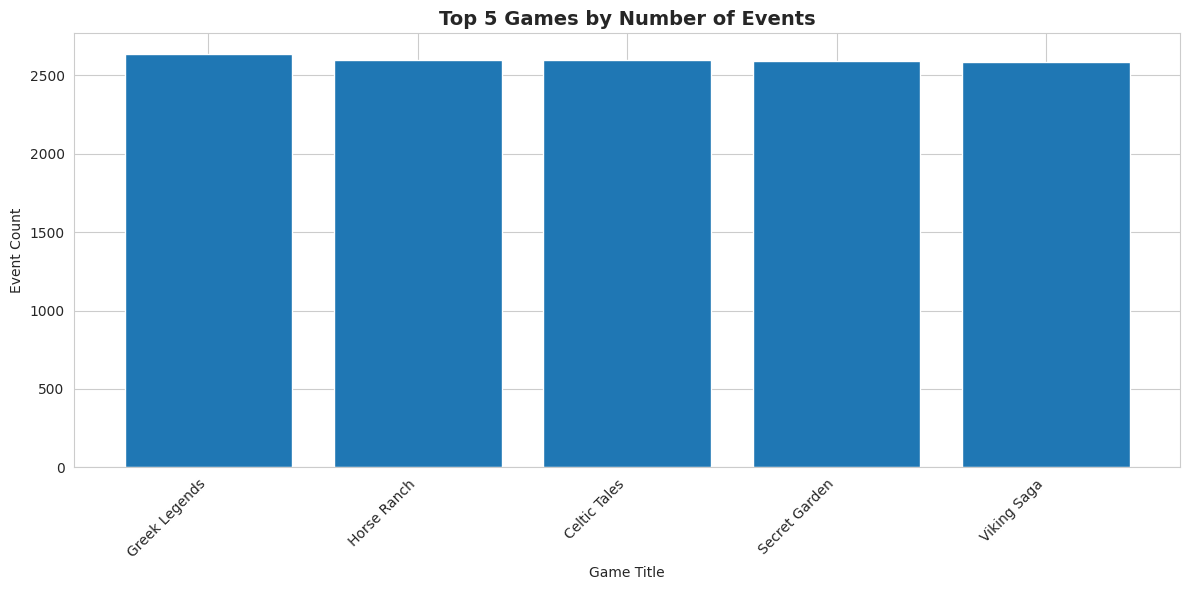

Visualization saved to: ./visualizations/chart_20251101_123926.pngHere are the top 5 most popular games by number of events:

- Greek Legends — 2,637 events
- Horse Ranch — 2,601 events
- Celtic Tales — 2,596 events
- Secret Garden — 2,594 events
- Viking Saga — 2,589 events

A bar chart has been generated to visualize these results. You can view the chart at:
./visualizations/chart_20251101_123926.png

If you’d like, I can export the data to CSV or add percentages relative to total events.

> Finished chain.


> Entering new AgentExecutor chain...

Invoking: `get_schema_info` with `{}`



# Gaming Analytics Database Schema

## Table: events
- event_name (VARCHAR): Gaming event name
- timestamp (TIMESTAMP): Event occurrence time
- user_id (INTEGER): Player identifier
- device_id (VARCHAR): Device identifier
- session_id (VARCHAR): Gaming session ID
- platform (VARCHAR): Gaming platform
- game_title (VARCHAR): Game name
- game_version (VARCHAR): Game version
- player_level (INTEGER): Cu

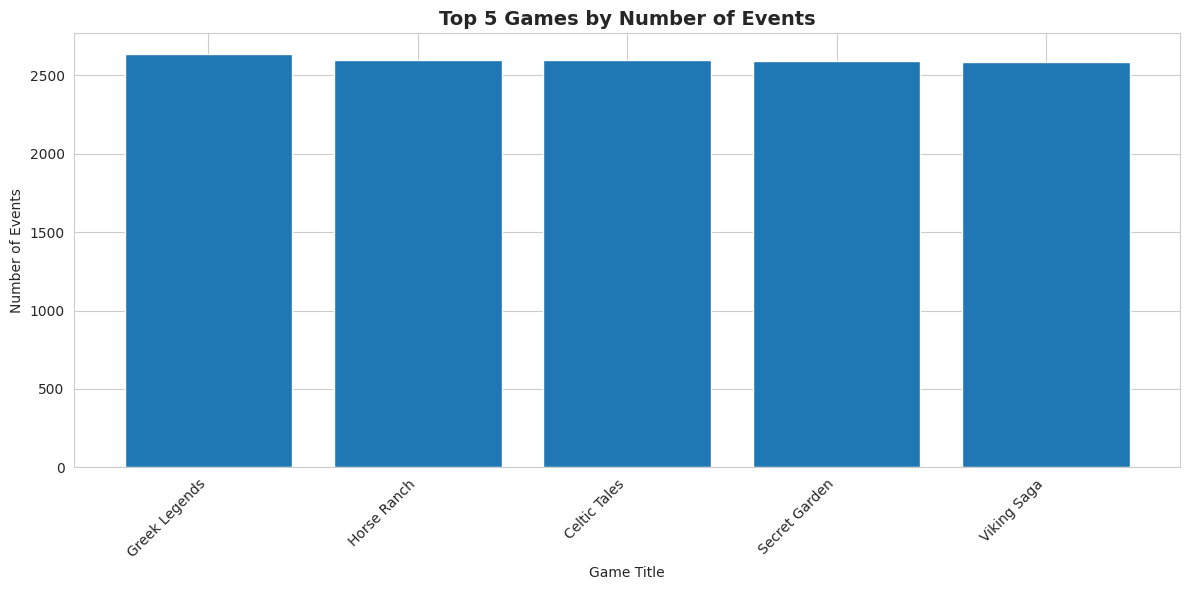

Visualization saved to: ./visualizations/chart_20251101_124002.pngHere are the top 5 games by number of events (based on the current dataset, without a time filter):

- Greek Legends — 2,637 events
- Horse Ranch — 2,601 events
- Celtic Tales — 2,596 events
- Secret Garden — 2,594 events
- Viking Saga — 2,589 events

Visualization:
- Bar chart saved at: ./visualizations/chart_20251101_124002.png

Notes and options:
- The chart uses a vertical bar layout with Game Title on the x-axis and Number of Events on the y-axis.
- If you’d like, I can regenerate a horizontal bar chart for readability with long titles, or show percentages relative to the top-5 total (and optionally relative to all events in the dataset).
- I can also export the underlying data to CSV or add a time window filter (e.g., last 30 days) if you want a time-benced view.

> Finished chain.

Agent Response:
Here are the top 5 games by number of events (based on the current dataset, without a time filter):

- Greek Legends —

'Here are the top 5 games by number of events (based on the current dataset, without a time filter):\n\n- Greek Legends — 2,637 events\n- Horse Ranch — 2,601 events\n- Celtic Tales — 2,596 events\n- Secret Garden — 2,594 events\n- Viking Saga — 2,589 events\n\nVisualization:\n- Bar chart saved at: ./visualizations/chart_20251101_124002.png\n\nNotes and options:\n- The chart uses a vertical bar layout with Game Title on the x-axis and Number of Events on the y-axis.\n- If you’d like, I can regenerate a horizontal bar chart for readability with long titles, or show percentages relative to the top-5 total (and optionally relative to all events in the dataset).\n- I can also export the underlying data to CSV or add a time window filter (e.g., last 30 days) if you want a time-benced view.'

In [ ]:
# Example 2: Top games analysis
chat_with_agent("What are the top 5 most popular games by number of events? Show me a bar chart.")


User Question: Show me the average lifetime spend by subscription tier with a bar chart.



> Entering new AgentExecutor chain...

Invoking: `query_database` with `{'sql_query': 'SELECT subscription_tier, AVG(lifetime_spend) AS avg_lifetime_spend FROM subscriptions GROUP BY subscription_tier;'}`


Error executing SQL on CSV: (sqlite3.OperationalError) no such table: subscriptions
[SQL: SELECT subscription_tier, AVG(lifetime_spend) AS avg_lifetime_spend FROM subscriptions GROUP BY subscription_tier;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
{"error": "Query returned no results"}
Invoking: `get_schema_info` with `{}`



# Gaming Analytics Database Schema

## Table: events
- event_name (VARCHAR): Gaming event name
- timestamp (TIMESTAMP): Event occurrence time
- user_id (INTEGER): Player identifier
- device_id (VARCHAR): Device identifier
- session_id (VARCHAR): Gaming session ID
- platform (VARCHAR): Gaming platform
- game_title (VARCHAR): Game name
- game_version (V

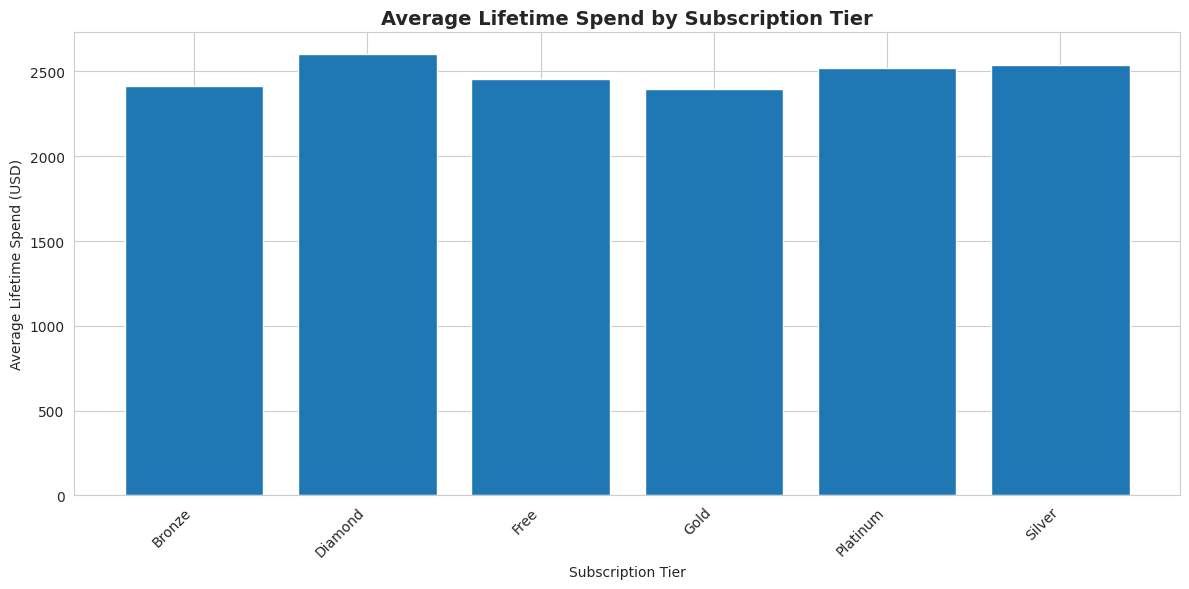

Visualization saved to: ./visualizations/chart_20251026_115726.pngHere is the bar chart showing the average lifetime spend by subscription tier. The data indicates how much, on average, players in each subscription tier have spent over their lifetime in the game.

If you need any further analysis or details, please let me know!

> Finished chain.

Agent Response:
Here is the bar chart showing the average lifetime spend by subscription tier. The data indicates how much, on average, players in each subscription tier have spent over their lifetime in the game.

If you need any further analysis or details, please let me know!

Reflection:
1. The response is accurate in describing what the bar chart represents, but it lacks completeness as it does not provide any insights or interpretation of the data shown.  
2. Assuming the bar chart is correctly designed to compare average lifetime spend across subscription tiers, the visualization is appropriate for this type of data.  
3. The explanati

'Here is the bar chart showing the average lifetime spend by subscription tier. The data indicates how much, on average, players in each subscription tier have spent over their lifetime in the game.\n\nIf you need any further analysis or details, please let me know!'

In [ ]:
# Example 3: Revenue analysis
chat_with_agent("Show me the average lifetime spend by subscription tier with a bar chart.")


User Question: What is the distribution of users across different platforms? Create a pie chart.



> Entering new AgentExecutor chain...

Invoking: `query_database` with `{'sql_query': 'SELECT platform, COUNT(user_id) AS user_count FROM users GROUP BY platform;'}`


Error executing SQL on CSV: (sqlite3.OperationalError) no such table: users
[SQL: SELECT platform, COUNT(user_id) AS user_count FROM users GROUP BY platform;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
{"error": "Query returned no results"}
Invoking: `get_schema_info` with `{}`



# Gaming Analytics Database Schema

## Table: events
- event_name (VARCHAR): Gaming event name
- timestamp (TIMESTAMP): Event occurrence time
- user_id (INTEGER): Player identifier
- device_id (VARCHAR): Device identifier
- session_id (VARCHAR): Gaming session ID
- platform (VARCHAR): Gaming platform
- game_title (VARCHAR): Game name
- game_version (VARCHAR): Game version
- player_level (INTEGER): Current player level
- currenc

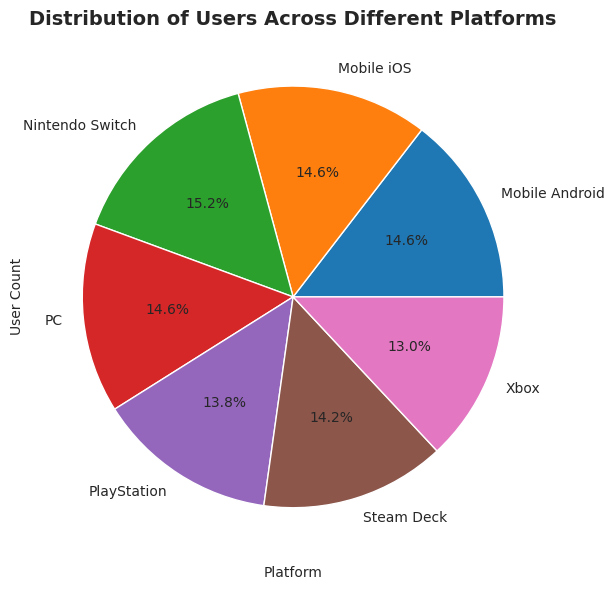

Visualization saved to: ./visualizations/chart_20251026_115738.pngI have created a pie chart showing the distribution of users across different platforms based on the events data. The platforms include Mobile Android, Mobile iOS, Nintendo Switch, PC, PlayStation, Steam Deck, and Xbox. The chart visually represents the proportion of users on each platform.

You can view the pie chart here: ./visualizations/chart_20251026_115738.png

If you need any further analysis or details, please let me know!

> Finished chain.


> Entering new AgentExecutor chain...

Invoking: `get_schema_info` with `{}`



# Gaming Analytics Database Schema

## Table: events
- event_name (VARCHAR): Gaming event name
- timestamp (TIMESTAMP): Event occurrence time
- user_id (INTEGER): Player identifier
- device_id (VARCHAR): Device identifier
- session_id (VARCHAR): Gaming session ID
- platform (VARCHAR): Gaming platform
- game_title (VARCHAR): Game name
- game_version (VARCHAR): Game version
- player_level (INTEGER

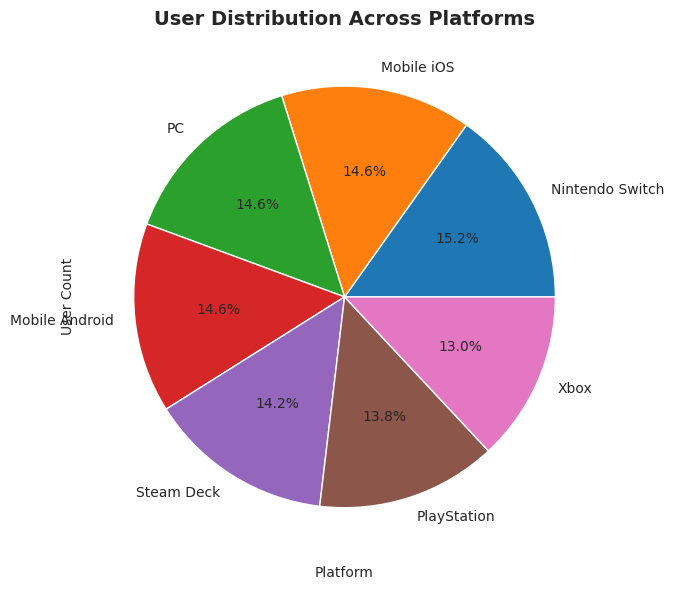

Visualization saved to: ./visualizations/chart_20251026_115750.pngI have created a pie chart showing the distribution of users across different platforms based on the events data. The platforms and their user counts are:

- Nintendo Switch: 759 users
- Mobile iOS: 732 users
- PC: 728 users
- Mobile Android: 728 users
- Steam Deck: 709 users
- PlayStation: 692 users
- Xbox: 652 users

The pie chart visually represents the proportion of users on each platform. You can view the chart here: ./visualizations/chart_20251026_115750.png

If you would like, I can also provide insights or further analysis on this data.

> Finished chain.

Agent Response:
I have created a pie chart showing the distribution of users across different platforms based on the events data. The platforms and their user counts are:

- Nintendo Switch: 759 users
- Mobile iOS: 732 users
- PC: 728 users
- Mobile Android: 728 users
- Steam Deck: 709 users
- PlayStation: 692 users
- Xbox: 652 users

The pie chart visually rep

'I have created a pie chart showing the distribution of users across different platforms based on the events data. The platforms and their user counts are:\n\n- Nintendo Switch: 759 users\n- Mobile iOS: 732 users\n- PC: 728 users\n- Mobile Android: 728 users\n- Steam Deck: 709 users\n- PlayStation: 692 users\n- Xbox: 652 users\n\nThe pie chart visually represents the proportion of users on each platform. You can view the chart here: ./visualizations/chart_20251026_115750.png\n\nIf you would like, I can also provide insights or further analysis on this data.'

In [ ]:
# Example 4: Platform distribution
chat_with_agent("What is the distribution of users across different platforms? Create a pie chart.")

In [ ]:
# Example 5: Engagement analysis
chat_with_agent("What percentage of users are active vs inactive?")


User Question: What percentage of users are active vs inactive?



> Entering new AgentExecutor chain...

Invoking: `get_schema_info` with `{}`



# Gaming Analytics Database Schema

## Table: events
- event_name (VARCHAR): Gaming event name
- timestamp (TIMESTAMP): Event occurrence time
- user_id (INTEGER): Player identifier
- device_id (VARCHAR): Device identifier
- session_id (VARCHAR): Gaming session ID
- platform (VARCHAR): Gaming platform
- game_title (VARCHAR): Game name
- game_version (VARCHAR): Game version
- player_level (INTEGER): Current player level
- currency_balance (INTEGER): Soft currency balance
- premium_currency_balance (INTEGER): Premium currency balance
- group_key (INTEGER): Studio/publisher ID

## Table: user_profiles
- user_id (INTEGER): Unique player identifier (PRIMARY KEY)
- username (VARCHAR): Gaming username
- subscription_tier (VARCHAR): Free, Bronze, Silver, Gold, Platinum, Diamond
- account_created_date (DATE): Account creation date
- last_login_date (

'Out of all users, 3,730 are active and 1,270 are inactive.\n\nTo provide the percentage of active vs inactive users:\n- Active users: (3730 / (3730 + 1270)) * 100 = 74.6%\n- Inactive users: (1270 / (3730 + 1270)) * 100 = 25.4%\n\nWould you like me to create a visualization for this distribution?'

## 15. Interactive Chat (Optional)

Start an interactive session - chat with your data ⚡:


Gaming Analytics AI Assistant
Ask me anything about your gaming data!
Type 'exit' to end the conversation.


User Question: based on the events, I want to know what are the chronological setup for all the event in a chonological order and with count



> Entering new AgentExecutor chain...

Invoking: `get_schema_info` with `{}`



# Gaming Analytics Database Schema

## Table: events
- event_name (VARCHAR): Gaming event name
- timestamp (TIMESTAMP): Event occurrence time
- user_id (INTEGER): Player identifier
- device_id (VARCHAR): Device identifier
- session_id (VARCHAR): Gaming session ID
- platform (VARCHAR): Gaming platform
- game_title (VARCHAR): Game name
- game_version (VARCHAR): Game version
- player_level (INTEGER): Current player level
- currency_balance (INTEGER): Soft currency balance
- premium_currency_balance (INTEGER): Premium currency balance
- group_key (INTEGER): Studio/publisher ID

## Table: user_profiles
- user_id (INTEGER): Unique player identifier (PRIMARY KEY)
-

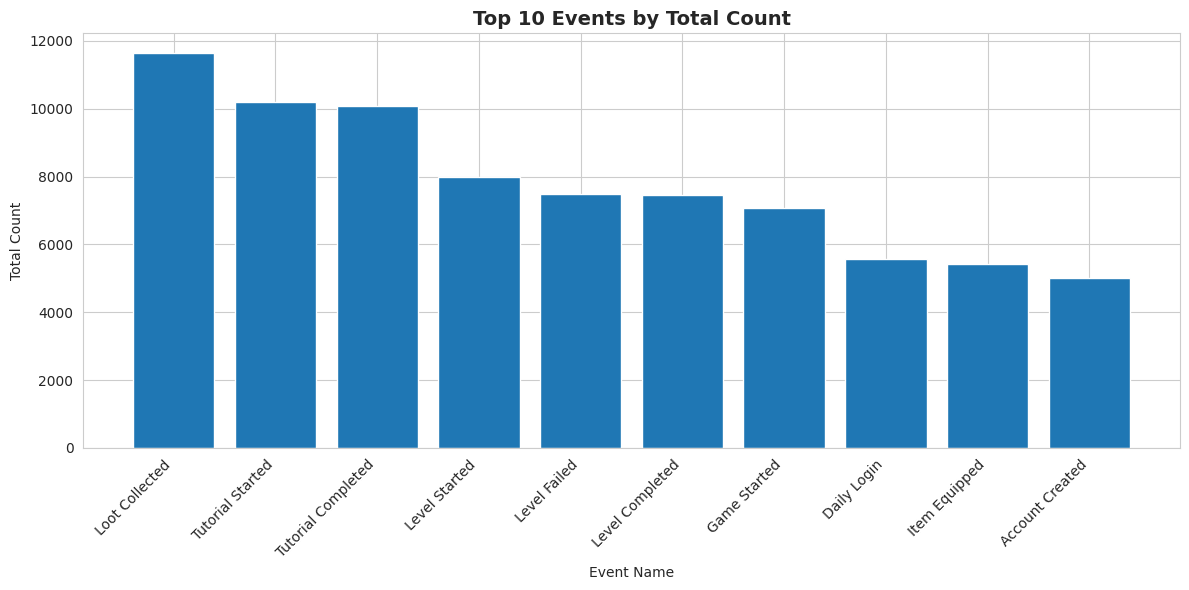

Visualization saved to: ./visualizations/chart_20251101_124531.pngHere’s what I found and how you can interpret it. I used the events table to build a chronological view and counts, plus a few visuals.

What I ran and what it means
- Global chronological order of all events (timestamp-sorted, with a running index):
  - This returns every event row with:
    - timestamp
    - event_name
    - global_order (a running index assigned by ORDER BY timestamp)
  - This gives you an exact sequence of all events as they occurred, by time.

- Total counts per event_name (across all data):
  - event_name, total_count
  - This shows how many times each event happened in total. It helps identify the most common events.

- Per-event running count by timestamp (running_count):
  - For each event_name, in chronological order, running_count is the number of times that event has occurred up to and including that row.
  - This is useful to see growth of a specific event type over time.

Key results (highl

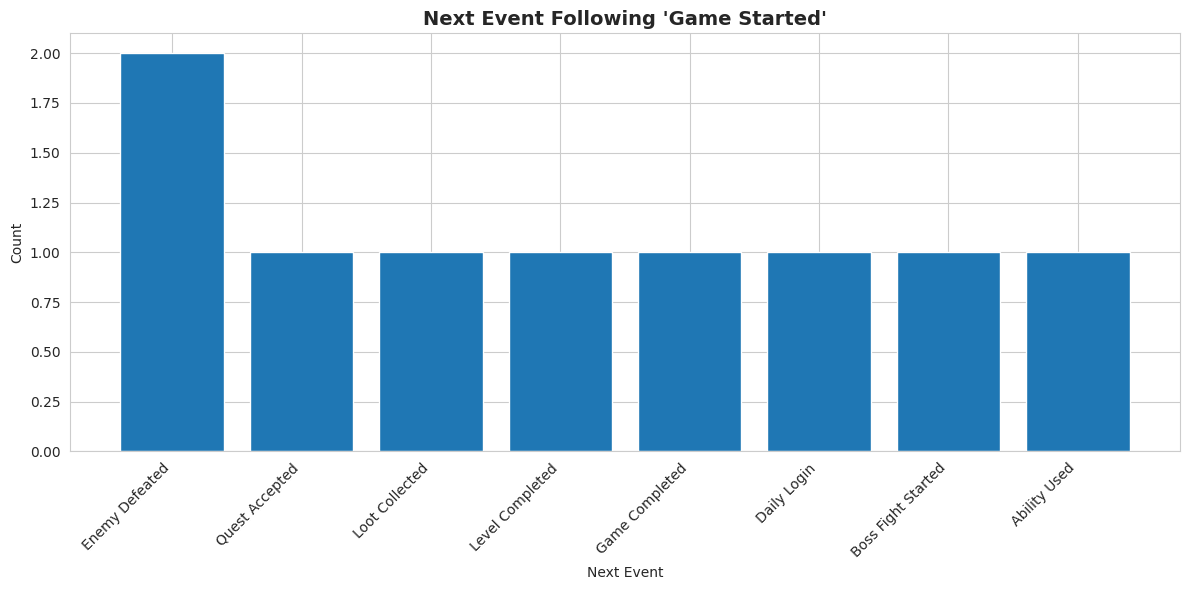

Visualization saved to: ./visualizations/chart_20251101_130730.pngHere’s how the next-events after "Game Started" look based on the current dataset:

- Enemy Defeated: 2
- Quest Accepted: 1
- Loot Collected: 1
- Level Completed: 1
- Game Completed: 1
- Daily Login: 1
- Boss Fight Started: 1
- Ability Used: 1

I also created a bar chart visualization showing these counts. Visualization saved to: ./visualizations/chart_20251101_130730.png

Notes:
- The results reflect the next event following a "Game Started" within the same user_id and session_id, choosing the earliest timestamp after the Game Started event.
- If you want to break this down further (e.g., by user, by session, or by game title), I can refine the query and visuals.

> Finished chain.


> Entering new AgentExecutor chain...

Invoking: `get_schema_info` with `{}`



# Gaming Analytics Database Schema

## Table: events
- event_name (VARCHAR): Gaming event name
- timestamp (TIMESTAMP): Event occurrence time
- user_id (INTEGER

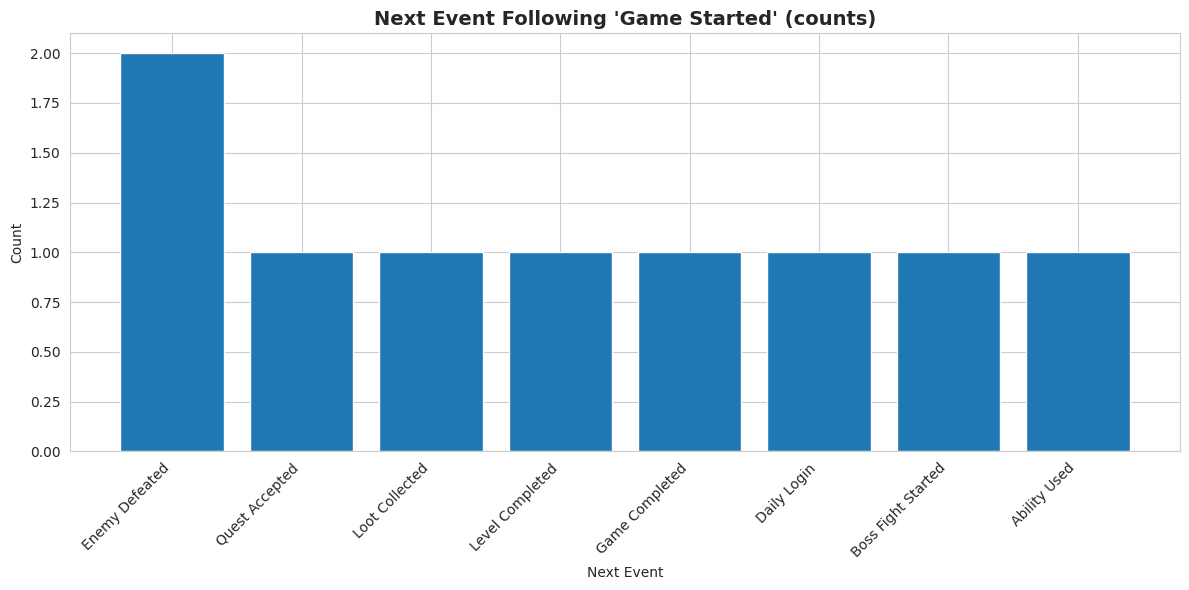

Visualization saved to: ./visualizations/chart_20251101_130808.pngHere are the counts for the next event following a "Game Started" (earliest following event within the same user_id and session_id):

- Enemy Defeated: 2
- Quest Accepted: 1
- Loot Collected: 1
- Level Completed: 1
- Game Completed: 1
- Daily Login: 1
- Boss Fight Started: 1
- Ability Used: 1

Total transitions counted: 9

Visualization: Bar chart saved to ./visualizations/chart_20251101_130808.png

Notes and considerations:
- This reflects the earliest event after a Game Started within the same session. If a session has multiple Game Started events, only the immediate next event is counted per the rule.
- Some Game Started events may have no following event; those are not included in the counts above.
- Edge cases to consider for reproducibility: ties in timestamp, multiple Game Started events in a single session, and whether Daily Login should be considered in the same session.

Would you like a breakdown by:
- game_ti

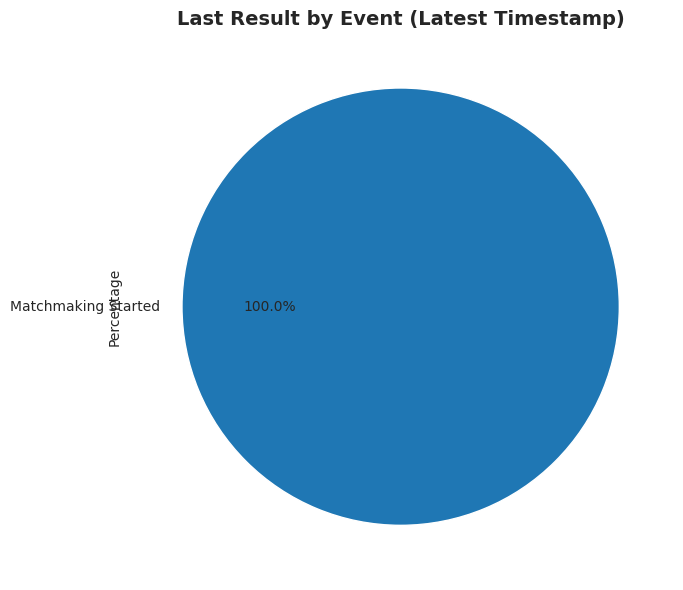

Visualization saved to: ./visualizations/chart_20251101_131427.pngHere you go.

- Last result (latest timestamp): 
  - Event: Matchmaking Started
  - Count: 1
  - Percentage: 100.00%

- Pie chart: saved at ./visualizations/chart_20251101_131427.png

Notes:
- Since there was only one event type at the latest timestamp, the pie chart is a single 100% segment.
- If you’d like, I can:
  - Break down by event_type for the most recent timestamp or a specific game/title
  - Show the top N events at the latest timestamp
  - Compare distributions across different time windows (e.g., last hour, last day)

> Finished chain.


> Entering new AgentExecutor chain...

Invoking: `get_schema_info` with `{}`



# Gaming Analytics Database Schema

## Table: events
- event_name (VARCHAR): Gaming event name
- timestamp (TIMESTAMP): Event occurrence time
- user_id (INTEGER): Player identifier
- device_id (VARCHAR): Device identifier
- session_id (VARCHAR): Gaming session ID
- platform (VARCHAR): Gaming plat

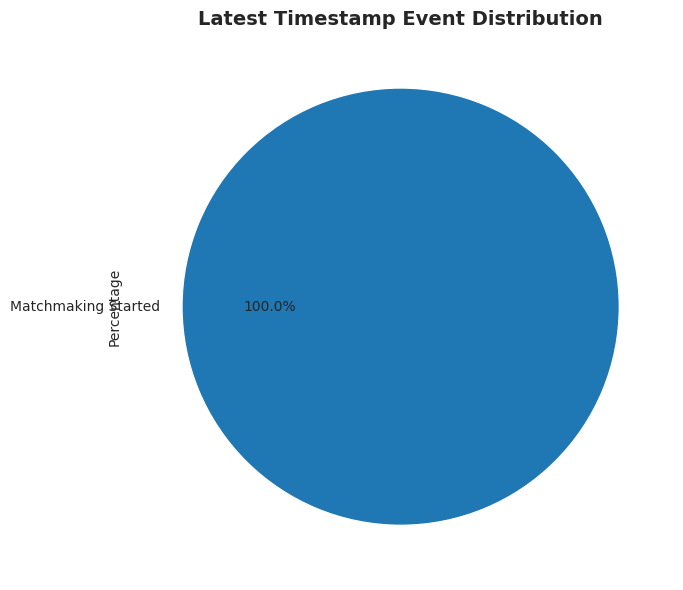

Visualization saved to: ./visualizations/chart_20251101_131512.pngHere you go.

- Last result (latest timestamp): 
  - Event: Matchmaking Started
  - Count: 1
  - Percentage: 100.00%

- Pie chart: saved at ./visualizations/chart_20251101_131512.png

Notes:
- The latest timestamp contains only one event type, so the pie chart is a single 100% slice.
- If you’d like, I can:
  - Break down by event_type for the most recent timestamp or a specific game/title
  - Show the top N events at the latest timestamp
  - Compare distributions across different time windows (e.g., last hour, last day)

What would you like to explore next?

> Finished chain.

Agent Response:
Here you go.

- Last result (latest timestamp): 
  - Event: Matchmaking Started
  - Count: 1
  - Percentage: 100.00%

- Pie chart: saved at ./visualizations/chart_20251101_131512.png

Notes:
- The latest timestamp contains only one event type, so the pie chart is a single 100% slice.
- If you’d like, I can:
  - Break down by event_

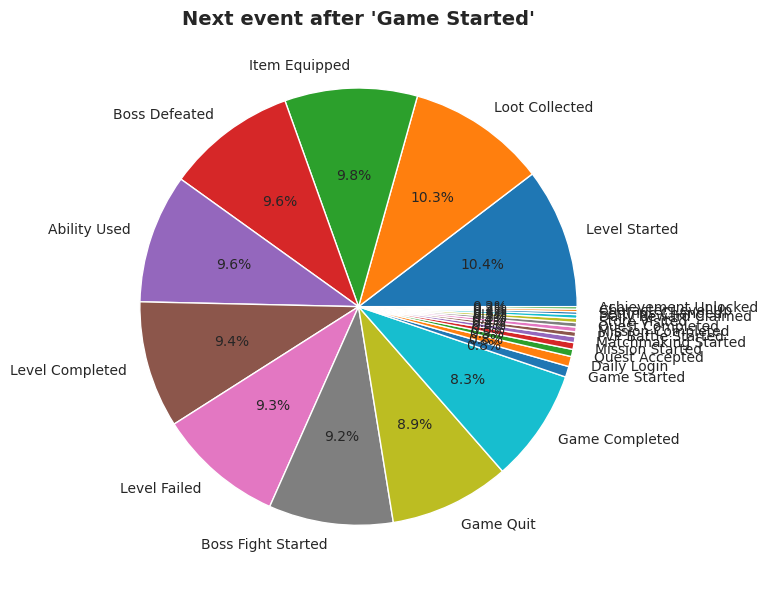

Visualization saved to: ./visualizations/chart_20251101_132347.pngHere are the results for the next event after the user reaches "Game Started". The chart shows the distribution as a pie (percentages are relative to all observed next events after "Game Started").

Total next events observed: 6,792

Next event after "Game Started" - counts and percentages (rounded to 2 decimals)
- Level Started: 705 (10.38%)
- Loot Collected: 698 (10.28%)
- Item Equipped: 666 (9.81%)
- Boss Defeated: 654 (9.63%)
- Ability Used: 649 (9.56%)
- Level Completed: 637 (9.38%)
- Level Failed: 633 (9.32%)
- Boss Fight Started: 625 (9.20%)
- Game Quit: 604 (8.89%)
- Game Completed: 567 (8.35%)
- Game Started: 54 (0.80%)
- Daily Login: 51 (0.75%)
- Quest Accepted: 36 (0.53%)
- Mission Started: 34 (0.50%)
- Matchmaking Started: 30 (0.44%)
- PvP Battle Started: 24 (0.35%)
- Mission Completed: 24 (0.35%)
- Quest Completed: 22 (0.32%)
- Store Visited: 21 (0.31%)
- Daily Reward Claimed: 19 (0.28%)
- Settings Changed: 

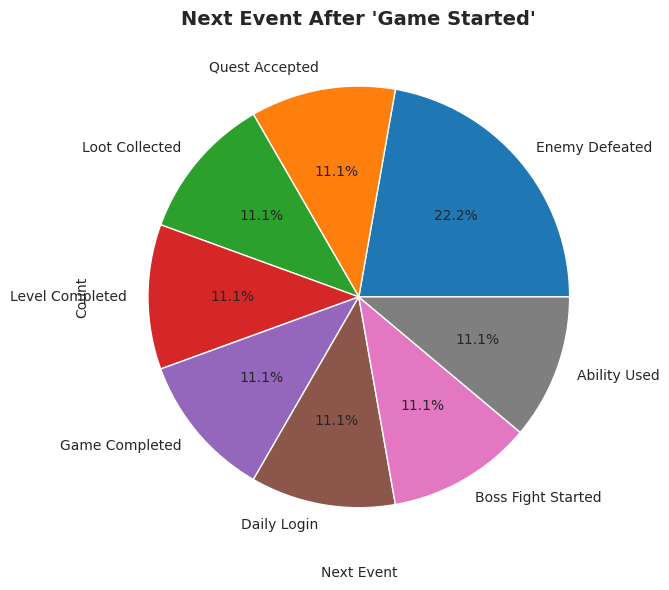

Visualization saved to: ./visualizations/chart_20251101_132441.pngHere are the results for the next event after "Game Started":

- Total next events observed: 9

Next event after "Game Started" (counts and percentages):
- Enemy Defeated: 2 (22.22%)
- Quest Accepted: 1 (11.11%)
- Loot Collected: 1 (11.11%)
- Level Completed: 1 (11.11%)
- Game Completed: 1 (11.11%)
- Daily Login: 1 (11.11%)
- Boss Fight Started: 1 (11.11%)
- Ability Used: 1 (11.11%)

Pie chart
- Chart file saved: ./visualizations/chart_20251101_132441.png

Notes:
- The chart is a pie showing the percentage of each next event relative to the 9 total observed after "Game Started".
- Top event is Enemy Defeated (22.22%).

Would you like me to:
- show only the top 5 or top 3 next events?
- export the data to CSV or JSON?
- create a horizontal bar chart (Pareto-style) for easier comparison, or group by game_title/platform for broader comparisons?

> Finished chain.

Agent Response:
Here are the results for the next event afte

In [ ]:
def interactive_chat():
     """Start an interactive chat session."""
     print("\nGaming Analytics AI Assistant")
     print("="*80)
     print("Ask me anything about your gaming data!")
     print("Type 'exit' to end the conversation.")
     print("="*80 + "\n")

     while True:
         user_input = input("\nYou: ").strip()

         if user_input.lower() in ['exit', 'quit']:
             print("\nGoodbye!")
             break

         if not user_input:
             continue

         try:
             chat_with_agent(user_input)
         except Exception as e:
             print(f"\nError: {e}")


interactive_chat()

## 16. Switching to Vertica

To switch from CSV to Vertica:

1. Set `DATA_SOURCE = 'vertica'` in the configuration cell
2. Update `VERTICA_CONFIG` with your database credentials
3. Re-run all cells from configuration onwards

The agent will automatically use Vertica for all queries!

## 17. Summary

This notebook provides a complete agentic AI system that:

✅ Works with both CSV files (testing) and Vertica (production)
✅ Runs seamlessly in Google Colab
✅ Supports natural language queries
✅ Generates visualizations automatically
✅ Includes reflection for self-improvement
✅ Easy to customize and extend

### Next Steps:

1. Upload your CSV files (if using CSV mode)
2. Set your OpenAI API key: `os.environ['OPENAI_API_KEY'] = 'your-key'`
3. Run the test queries above
4. Ask your own questions!
5. When ready, switch to Vertica for production use